# Instructions for Project 1 - Sentiment Analysis



Hello everyone, this is Zhaowei Wang. I am glad to host the first project. My email is *zwanggy@connect.ust.hk*. Feel free to send me an email if you have any problem regarding this project.

In this project, you will try to work on a sentiment analysis task.
You will build a model to predict the scores (a.k.a. the "label" column in datasets, from 1 to 5) of each review.
For each review, you are given a piece of text. You can consider the predicted variables as categorical, ordinal or numerical.

Just a kind note: The codes and techniques introduced in the previous tutorials may come in handy. You can refer to the .ipynb notebooks for details.

## Important dates, submission requirements and grading policy
**Important dates:**
- *March 16, 2024 (Saturday)*: Project starts
- *March 23, 2024 (Saturday)* Release the validation score of baselines
- *April 6, 2024, 23:59 (Saturday)*: `Submission Deadline`

**Submission requirements:**  
Each team leader is required to submit the groupNo.zip file on the Canvas. It shoud contain
- `pred.csv`: Predictions on test data (please make sure you can successfully evaluate your validation predictions on the validation data with the help of evaluate.py). The file should contain two so-called columns, which are `id`
and `label`.
- report (1-2 pages of pdf)
- code (Frameworks and programming languages are not restricted)

**Grading policy:**  
We will check your report with your code and your model performance (in terms of Accuracy) on the test set.

| Grade | Classifier (80%)                                                   | Report (20%)                      |
|-------|--------------------------------------------------------------------|-----------------------------------|
| 50%   | Example code in tutorials or in Project 1 without any modification | submission                        |
| 75%   | A method that can outperform the easy baseline  | algorithm you used                |
| 95%   | A method that can outperform the hard baseline                     | detailed explanation and analysis, such as explorative data analysis, hyperparameters and ablation studies  |
| 100%  | A method that can outperform the hard baseline with at least one excellent idea  | excellent ideas, detailed explanation and solid analysis |

## Instruction Content
In this notebook, you are provided with the code snippets to start with.

The content follows previous lectures and tutorials. But some potentially useful python packages are also mentioned.

1. Loading data and saving predictions
    1. Loading data
    1. Saving predictions to file
1. Preprocessing
    1. Text data processing recap
    1. Explorative data analysis
1. Learning Baselines

# 1. Loading data and saving predictions

The same as previous tutorials, we use `pandas` as the basic tool to load & dump the data.
The key ingredient of our operation is the `DataFrame` in pandas.

In [1]:
import pandas as pd

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.linear_model import LogisticRegression

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download("wordnet")

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [4]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import stopwords
import string
stopwords = set(stopwords.words('english'))
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

In [5]:
!pip install spacy

In [6]:
!pip install torch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 41.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 49.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 67.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 728.3 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 4.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 4.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 37.0 MB/s eta 0:00:00


In [7]:
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
import tqdm

In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [9]:
from matplotlib import pyplot as plt
from collections import Counter,OrderedDict

In [76]:
# if you use Google Colab, un-comment this cell, modify `path_to_data` if needed, and run to mount data to `data`
from google.colab import drive
drive.mount('/content/drive')

path_to_data = '/content/drive/MyDrive/Colab Notebooks/comp4332/Project1/Cleaned_Data'
!rm -f data
!ln -s '/content/drive/MyDrive/Colab Notebooks/comp4332/Project1/Cleaned_Data' data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### A. Loading data

The following code shows how to load the datasets for this project.  
Among which, we do not release the labels (the "label" column) for the test set.
You may evaluate your trained model on the validation set instead.
However, your submitted predictions (``pred.csv``) should be generated on the test set.

Each year we release different data, so old models are not guaranteed to solve the new data.

In [77]:
def load_data(split_name='train', columns=['text', 'label'], folder='data'):
    '''
        "split_name" may be set as 'train', 'valid' or 'test' to load the corresponding dataset.

        You may also specify the column names to load any columns in the .csv data file.
        Among many, "text" can be used as model input, and "label" column is the labels (sentiment).
    '''
    try:
        print(f"select [{', '.join(columns)}] columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        df = df.loc[:,columns]
        print("Success")
        return df
    except:
        print(f"Failed loading specified columns... Returning all columns from the {split_name} split")
        df = pd.read_csv(f'{folder}/{split_name}.csv')
        return df

Then you can extract the data by specifying the desired split and columns

In [78]:
train_df = load_data('train', columns=['text', 'label'], folder='data')
valid_df = load_data('valid', columns=['text', 'label'], folder='data')
# the test set labels (the 'label' column) are unavailable! So the following code will instead return all columns
test_df = load_data('test_no_label', columns=['id', 'text'], folder='data')

select [text, label] columns from the train split
Success
select [text, label] columns from the valid split
Success
select [id, text] columns from the test_no_label split
Success


# No missing values in the dataset

In [ ]:
train_df

,text,label
0,Two Wolfgang Petersen directed films together ...,5
1,For fans of the series and the movies\nthis fi...,4
2,"I love the movie. The Blu-ray was fine, but it...",3
3,You don't know what is going on until the end ...,3
4,"We only watched a few minutes of the movie, du...",1
...,...,...
17995,The movie could only be played in Europe so it...,3
17996,Don't waist your time on this slow moving effo...,2
17997,The first 3-D feature film ever made! Recommen...,5
17998,"Hitchcock made some really terrible films, and...",1


In [ ]:
train_df.isnull().sum()

text     0
label    0
dtype: int64

The size of training dataset, validation dataset and testing dataset respectively

In [ ]:
print(len(train_df), len(valid_df), len(test_df))

18000 2000 4000


#This part is to visualise text and labels to obtain better understanding on the data

##Review Analysis

46       1
1        1
44       1
43       3
4        4
42       5
14       7
41      20
39     431
40     435
38     448
37     455
35     481
36     510
34     534
32     562
33     569
19     577
18     580
31     587
17     645
16     651
29     664
30     665
28     672
27     716
15     742
26     777
25     814
24     902
23    1004
22    1062
21    1172
20    1303
Name: count, dtype: int64
average number of words in reviews:  26.018722222222223
(46,)


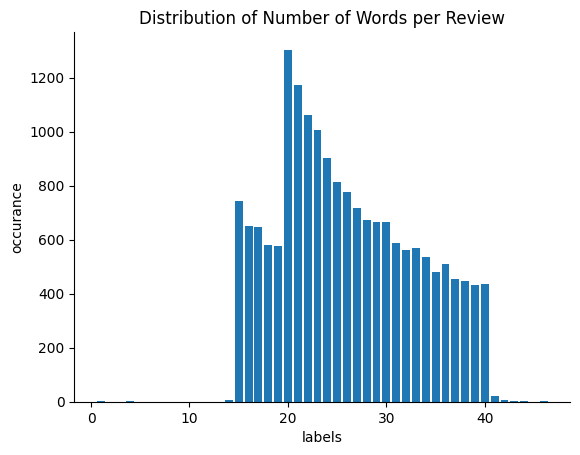

In [13]:
from matplotlib import pyplot as plt
from collections import Counter,OrderedDict
text = pd.DataFrame([len(s.split()) for s in train_df["text"]])
count_df = text.value_counts().sort_values()
print(count_df)
print("average number of words in reviews: ",text.mean()[0])
#count_df.plot(kind = "bar",title = "Number of Words in Reviews")
print(count_df.index[0])
index = [i[0] for i in count_df.index]
plt.bar(index,count_df.values)
plt.title("Distribution of Number of Words per Review")
plt.xlabel("labels")
plt.ylabel("occurance")
plt.gca().spines[['top', 'right',]].set_visible(False)

In [14]:
def preprocessForstopwordsDetection(s:list):
  temp = [w.lower() for w in s]
  temp = [lemmatizer.lemmatize(word) for word in temp]
  temp = " ".join(temp)
  temp = temp.translate(str.maketrans('', '', string.punctuation))
  return temp

In [15]:
from nltk import ngrams
for label in range(1,6):
  text = train_df.loc[train_df.label == label, 'text'].values
  text = preprocessForstopwordsDetection(text)
  text = [i for i in text.split() if i not in stopwords]
  text_unigrams = [i for i in ngrams(text, 1)]
  print(Counter(text_unigrams).most_common(15))

[(('movie',), 1253), (('one',), 375), (('dvd',), 337), (('like',), 317), (('film',), 302), (('bad',), 301), (('time',), 263), (('watch',), 261), (('good',), 253), (('would',), 241), (('dont',), 226), (('waste',), 222), (('movies',), 199), (('even',), 192), (('really',), 185)]
[(('movie',), 926), (('like',), 344), (('good',), 336), (('one',), 302), (('film',), 234), (('story',), 186), (('much',), 185), (('better',), 175), (('didnt',), 175), (('watch',), 164), (('great',), 161), (('would',), 157), (('acting',), 156), (('movies',), 150), (('time',), 145)]
[(('movie',), 2284), (('good',), 1251), (('like',), 589), (('one',), 581), (('great',), 565), (('story',), 559), (('watch',), 516), (('film',), 469), (('movies',), 397), (('would',), 384), (('better',), 367), (('time',), 358), (('much',), 345), (('ok',), 324), (('really',), 303)]
[(('movie',), 2507), (('good',), 1594), (('great',), 1067), (('one',), 754), (('like',), 588), (('story',), 561), (('film',), 496), (('watch',), 483), (('movies

In [ ]:
  text = preprocessForstopwordsDetection(train_df["text"].values)
  text = [i for i in text.split() if i not in stopwords]
  print("the total number of unique words in the dataset = ", len(set(text)))

the total number of unique words in the dataset =  18865


##Label Visualisation
indication of class imbalance issue

{1: 2522, 2: 1971, 3: 4480, 4: 4481, 5: 4546}


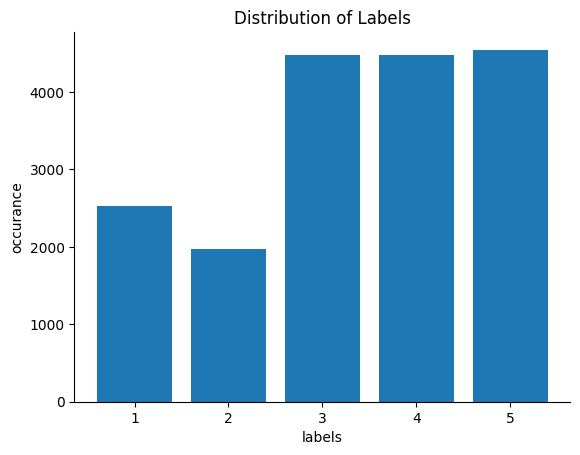

In [16]:
count_dict = dict(Counter(train_df["label"]))
count_dict = dict(sorted(count_dict.items()))
print(count_dict)
plt.bar(range(len(count_dict)), list(count_dict.values()), tick_label=list(count_dict.keys()))
plt.title("Distribution of Labels")
plt.xlabel("labels")
plt.ylabel("occurance")
plt.gca().spines[['top', 'right',]].set_visible(False)

## 2. Preprocessing

Here are some preprocessing examples for your reference. For more details you may refer to the previous tutorials.

### Text data processing


```

In [19]:
import re
import spacy
nlp = spacy.load('en_core_web_sm')
#print(type(string.punctuation))
#!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
'''def spellingcorrection(tokens:list):
  symspell = SymSpell()
  correct_spellings = []
  for token in tokens:
      x = symspell.lookup(token,Verbosity.CLOSEST,max_edit_distance=2,include_unknown=True)[0].__str__()
      y = x.split(',')[0]
      correct_spellings.append(y)
  return correct_spellings'''

def lemmatize(tokens:list):
  return [lemmatizer.lemmatize(word) for word in tokens]

def punctuationRemoval(s:str):
  s = s.translate(str.maketrans('', '', string.punctuation))
  return s

def partialpunctuationRemoval(s:str):
  s = s.translate(str.maketrans('', '', ",."))
  return s

def hyperlinksRemoval(s:str):
  s_processed = re.sub(r'^https?:\/\/.*[\r\n]*', '', s, flags=re.MULTILINE)
  p = re.compile(r'<.*?>')
  return p.sub("",s_processed)

def specialcharacterRemoval(s:str):
  return s.translate(str.maketrans('', '', "\t\n"))

def oneLetterWordRemoval(t:list):
  return [w for w in t if len(w) > 1]

def nametextRemoval(s:str):
  doc = nlp(s)
  cleaned_text = []
  for token in doc:
      if token.ent_type_ != "PERSON":
          cleaned_text.append(token.text)
  cleaned_text = " ".join(cleaned_text)
  return cleaned_text

def spacyRemoval(s:str):
  doc = nlp(s)
  return " ".join([e.text for e in doc.ents if e.label_ not in ('DATE', 'TIME', 'ORDINAL', 'CARDINAL','PERSON')])

def lower(s):
    """
    :param s: a string.
    return a string with lower characters
    Note that we allow the input to be nested string of a list.
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: 'text mining is to identify useful information.'
    """
    if isinstance(s, list):
        return [lower(t) for t in s]
    if isinstance(s, str):
        return s.lower()
    else:
        raise NotImplementedError("unknown datatype")


def tokenize(text):
    """
    :param text: a doc with multiple sentences, type: str
    return a word list, type: list
    e.g.
    Input: 'Text mining is to identify useful information.'
    Output: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    """
    return nltk.word_tokenize(text)


def stem(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of stemmed words, type: list
    e.g.
    Input: ['Text', 'mining', 'is', 'to', 'identify', 'useful', 'information', '.']
    Output: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     results.append(ps.stem(token))
    # return results

    return [ps.stem(token) for token in tokens]

def n_gram(tokens:list, n=1):
    """
    :param tokens: a list of tokens, type: list
    :param n: the corresponding n-gram, type: int
    return a list of n-gram tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.'], 2
    Output: ['text mine', 'mine is', 'is to', 'to identifi', 'identifi use', 'use inform', 'inform .']
    """
    if n == 1:
      return tokens
    else:
      results = list()
      for i in range(len(tokens)-n+1):
          # tokens[i:i+n] will return a sublist from i th to i+n th (i+n th is not included)
          results.append(" ".join(str(v) for v in tokens[i:i+n]))
      return results

def filter_stopwords(tokens):
    """
    :param tokens: a list of tokens, type: list
    return a list of filtered tokens, type: list
    e.g.
    Input: ['text', 'mine', 'is', 'to', 'identifi', 'use', 'inform', '.']
    Output: ['text', 'mine', 'identifi', 'use', 'inform', '.']
    """
    ### equivalent code
    # results = list()
    # for token in tokens:
    #     if token not in stopwords and not token.isnumeric():
    #         results.append(token)
    # return results

    return [token for token in tokens if token not in stopwords and not token.isnumeric()]

import numpy as np

def get_onehot_vector(feats, feats_dict):
    """
    :param data: a list of features, type: list
    :param feats_dict: a dict from features to indices, type: dict
    return a feature vector,
    """
    # initialize the vector as all zeros
    vector = np.zeros(len(feats_dict), dtype=np.float)
    for f in feats:
        # get the feature index, return -1 if the feature is not existed
        f_idx = feats_dict.get(f, -1)
        if f_idx != -1:
            # set the corresponding element as 1
            vector[f_idx] = 1
    return vector

##undersampling implementation
we will calculate the class weight for each class and apply them to our model training

In [20]:
#undersampling
import numpy as np
count_dict = dict(Counter(train_df["label"]))
count_dict = dict(sorted(count_dict.items()))
print(count_dict)
bin_list = np.array(list(count_dict.values()))
num_data = len(train_df["label"])
num_class = 5
class_weight = count_dict
for i in count_dict:
  w = num_data/(5*count_dict[i])
  class_weight[i] = w
print(class_weight)

{1: 2522, 2: 1971, 3: 4480, 4: 4481, 5: 4546}
{1: 1.4274385408406027, 2: 1.82648401826484, 3: 0.8035714285714286, 4: 0.8033920999776836, 5: 0.7919049714034316}


##Oversampling implementation
we will try to oversample the data to make the class more balanced

In [21]:
from imblearn.over_sampling import RandomOverSampler

In [22]:
ros = RandomOverSampler(random_state=777)

#Data Preprocessing Testing:

### we use baseline model for data preprocessing testing - TF-IDF + LR
we found that combining unigrams and bigrams gives the best result, we also implement several preprocessing methods to boost accuracy, please see the report for details.

In [57]:
train_df = load_data('train')
valid_df = load_data('valid')
x_train = train_df['text']
y_train = train_df['label']
x_valid = valid_df['text']
y_valid = valid_df['label']

select [text, label] columns from the train split
Success
select [text, label] columns from the valid split
Success


In [24]:
def joinListToString(l:list)->str:
  return " ".join(l)

In [58]:
train_text = x_train.map(hyperlinksRemoval).map(specialcharacterRemoval).map(partialpunctuationRemoval)
valid_text = x_valid.map(hyperlinksRemoval).map(specialcharacterRemoval).map(partialpunctuationRemoval)

In [ ]:
#train_text = train_text.map(joinListToString)
#valid_text = valid_text.map(joinListToString)

In [26]:
train_text

0        Two Wolfgang Petersen directed films together ...
1        For fans of the series and the moviesthis film...
2        I love the movie The Blu-ray was fine but it c...
3        You don't know what is going on until the end ...
4        We only watched a few minutes of the movie due...
                               ...                        
17995    The movie could only be played in Europe so it...
17996    Don't waist your time on this slow moving effo...
17997    The first 3-D feature film ever made! Recommen...
17998    Hitchcock made some really terrible films and ...
17999    It's okay - not my favorite version but Instan...
Name: text, Length: 18000, dtype: object

In [55]:
import regex
from nltk.tokenize import RegexpTokenizer
tokenizer1 = RegexpTokenizer(r'\w+|[^\w\s]+')

In [59]:
def fitTFIDFandLR(x_train, y_train, x_test,y_test,classWeight = None,n_gram = (1,1),resample = False):
  tfidf = TfidfVectorizer(tokenizer=tokenizer1.tokenize,ngram_range = n_gram)
  lr = LogisticRegression(class_weight=classWeight, max_iter=1000)
  tfidf.fit(x_train)
  x_train_vectorized = tfidf.transform(x_train)
  x_valid_vectorized = tfidf.transform(x_valid)
  y_train_mod = y_train
  if (resample):
    x_train_vectorized, y_train_mod = ros.fit_resample(x_train_vectorized, y_train_mod)
    #this is to show the distribution of class label after resampling
    #count_dict = dict(Counter(y_train_mod))
    #count_dict = dict(sorted(count_dict.items()))
    #plt.bar(range(len(count_dict)), list(count_dict.values()), tick_label=list(count_dict.keys()))
    #plt.title("Distribution of Labels")
    #plt.xlabel("labels")
    #plt.ylabel("occurance")
    #plt.gca().spines[['top', 'right',]].set_visible(False)
    #plt.show()
  lr.fit(x_train_vectorized, y_train_mod)
  #predictions
  y_pred = lr.predict(x_valid_vectorized)
  print(classification_report(y_valid, y_pred))
  print("\n\n")
  print(confusion_matrix(y_valid, y_pred))
  print('accuracy', np.mean(y_valid == y_pred))
  return tfidf, lr


With Undersampling

In [60]:
fitTFIDFandLR(train_text,y_train,valid_text,y_valid,classWeight = class_weight,n_gram = (1,2),resample = False)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.57      0.60      0.58       295
           2       0.34      0.39      0.36       198
           3       0.54      0.50      0.52       508
           4       0.50      0.43      0.46       523
           5       0.63      0.71      0.67       476

    accuracy                           0.54      2000
   macro avg       0.52      0.53      0.52      2000
weighted avg       0.54      0.54      0.53      2000




[[176  54  37  13  15]
 [ 54  78  48  12   6]
 [ 40  65 254 113  36]
 [ 26  25 106 226 140]
 [ 14   8  25  89 340]]
accuracy 0.537


(TfidfVectorizer(ngram_range=(1, 2),
                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>),
 LogisticRegression(class_weight={1: 1.4274385408406027, 2: 1.82648401826484,
                                  3: 0.8035714285714286, 4: 0.8033920999776836,
                                  5: 0.7919049714034316},
                    max_iter=1000))

With OverSampling

In [61]:
best_tfidf, best_lr = fitTFIDFandLR(train_text,y_train,valid_text,y_valid,classWeight = None,n_gram = (1,2),resample = True)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.57      0.59      0.58       295
           2       0.36      0.36      0.36       198
           3       0.54      0.52      0.53       508
           4       0.51      0.45      0.48       523
           5       0.64      0.72      0.68       476

    accuracy                           0.54      2000
   macro avg       0.52      0.53      0.52      2000
weighted avg       0.54      0.54      0.54      2000




[[174  49  41  13  18]
 [ 55  71  53  13   6]
 [ 38  52 266 116  36]
 [ 25  18 109 235 136]
 [ 14   5  27  87 343]]
accuracy 0.5445


In [63]:
print(best_tfidf)
print(best_lr)

TfidfVectorizer(ngram_range=(1, 2),
                tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>)
LogisticRegression(max_iter=1000)


Without Resampling

In [62]:
fitTFIDFandLR(train_text,y_train,valid_text,y_valid,classWeight = None,n_gram = (1,2),resample = False)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


              precision    recall  f1-score   support

           1       0.62      0.53      0.57       295
           2       0.50      0.12      0.20       198
           3       0.49      0.62      0.54       508
           4       0.49      0.46      0.47       523
           5       0.61      0.73      0.67       476

    accuracy                           0.54      2000
   macro avg       0.54      0.49      0.49      2000
weighted avg       0.54      0.54      0.52      2000




[[156  15  74  20  30]
 [ 50  24  96  18  10]
 [ 27   7 315 119  40]
 [ 14   1 130 238 140]
 [  4   1  34  89 348]]
accuracy 0.5405


(TfidfVectorizer(ngram_range=(1, 2),
                 tokenizer=<bound method RegexpTokenizer.tokenize of RegexpTokenizer(pattern='\\w+|[^\\w\\s]+', gaps=False, discard_empty=True, flags=re.UNICODE|re.MULTILINE|re.DOTALL)>),
 LogisticRegression(max_iter=1000))

##Other Machine Learning model we tried

###OneVSAll, OneVSOne and output code Classifier

In [29]:
train_text = x_train.map(hyperlinksRemoval).map(specialcharacterRemoval).map(partialpunctuationRemoval)
valid_text = x_valid.map(hyperlinksRemoval).map(specialcharacterRemoval).map(partialpunctuationRemoval)

In [30]:
from sklearn.multiclass import OneVsRestClassifier,OneVsOneClassifier,OutputCodeClassifier #53.75 #53.85 #0.5005
from sklearn.svm import SVC
def oneVSall(x_train, y_train, x_test,y_test,classWeight = None,n_gram = (1,1),resample = False):
  tfidf = TfidfVectorizer(tokenizer=tokenizer1.tokenize,ngram_range = n_gram)
  lr = OutputCodeClassifier(SVC())
  tfidf.fit(x_train)
  x_train_vectorized = tfidf.transform(x_train)
  x_valid_vectorized = tfidf.transform(x_valid)
  y_train_mod = y_train
  if (resample):
    x_train_vectorized, y_train_mod = ros.fit_resample(x_train_vectorized, y_train_mod)
    #this is to show the distribution of class label after resampling
    #count_dict = dict(Counter(y_train_mod))
    #count_dict = dict(sorted(count_dict.items()))
    #plt.bar(range(len(count_dict)), list(count_dict.values()), tick_label=list(count_dict.keys()))
    #plt.title("Distribution of Labels")
    #plt.xlabel("labels")
    #plt.ylabel("occurance")
    #plt.gca().spines[['top', 'right',]].set_visible(False)
    #plt.show()
  lr.fit(x_train_vectorized, y_train_mod)
  #predictions
  y_pred = lr.predict(x_valid_vectorized)
  print(classification_report(y_valid, y_pred))
  print("\n\n")
  print(confusion_matrix(y_valid, y_pred))
  print('accuracy', np.mean(y_valid == y_pred))

In [ ]:
oneVSall(train_text,y_train,valid_text,y_valid, classWeight = None,n_gram = (1,2),resample = True)

              precision    recall  f1-score   support

           1       0.76      0.40      0.52       295
           2       0.41      0.30      0.34       198
           3       0.56      0.45      0.50       508
           4       0.52      0.36      0.43       523
           5       0.44      0.86      0.58       476

    accuracy                           0.50      2000
   macro avg       0.54      0.47      0.47      2000
weighted avg       0.53      0.50      0.49      2000




[[117  36  31  18  93]
 [ 25  59  50   9  55]
 [  9  38 227  99 135]
 [  3  10  83 189 238]
 [  0   2  15  50 409]]
accuracy 0.5005


## Deep Learning model

This part is to try to finetune the baseline CNN model provided, and try other deep learning models

In [31]:
train_text = train_df['text'].map(hyperlinksRemoval).map(specialcharacterRemoval).map(partialpunctuationRemoval).map(tokenize)
valid_text = valid_df['text'].map(hyperlinksRemoval).map(specialcharacterRemoval).map(partialpunctuationRemoval).map(tokenize)

In [32]:
min_N = 1
max_N = 2
train_text_ngrams = []
valid_text_ngrams = []
for i in range(len(train_text)):
  ngrams = []
  for k in range(len(train_text[i])):
    for j in range(k+min_N, min(k+max_N, len(train_text[i]))+1):
      ngrams.append(' '.join(train_text[i][k:j]))
  train_text_ngrams.append(ngrams)
for i in range(len(valid_text)):
  ngrams = []
  for k in range(len(valid_text[i])):
    for j in range(k+min_N, min(k+max_N, len(valid_text[i]))+1):
      ngrams.append(' '.join(valid_text[i][k:j]))
  valid_text_ngrams.append(ngrams)

In [33]:
train_text_ngrams[:10]

[['Two',
  'Two Wolfgang',
  'Wolfgang',
  'Wolfgang Petersen',
  'Petersen',
  'Petersen directed',
  'directed',
  'directed films',
  'films',
  'films together',
  'together',
  'together in',
  'in',
  'in one',
  'one',
  'one package',
  'package',
  'package is',
  'is',
  'is all',
  'all',
  'all you',
  'you',
  'you could',
  'could',
  'could want',
  'want',
  'want with',
  'with',
  'with fine',
  'fine',
  'fine picture',
  'picture',
  'picture quality',
  'quality',
  'quality and',
  'and',
  'and all',
  'all',
  'all the',
  'the',
  'the extras',
  'extras',
  'extras from',
  'from',
  'from the',
  'the',
  'the old',
  'old',
  'old DVDs',
  'DVDs',
  "DVDs ''",
  "''",
  "'' Air",
  'Air',
  'Air Force',
  'Force',
  'Force One',
  'One',
  "One ''",
  "''",
  "'' in",
  'in',
  'in particular',
  'particular',
  'particular is',
  'is',
  'is excellent',
  'excellent'],
 ['For',
  'For fans',
  'fans',
  'fans of',
  'of',
  'of the',
  'the',
  'the series'

In [34]:
max_length = max([len(data) for data in train_text_ngrams])
print(max_length)

121


In [35]:
word2id = {}
for tokens in train_text:
    for t in tokens:
        if not t in word2id:
            word2id[t] = len(word2id)
word2id['<pad>'] = len(word2id)

In [36]:
def texts_to_id_seq(texts, padding_length=50):
    records = []
    for tokens in texts:
        record = []
        for t in tokens:
            record.append(word2id.get(t, len(word2id)))
        if len(record) >= padding_length:
            records.append(record[:padding_length])
        else:
            records.append(record + [word2id['<pad>']] * (padding_length - len(record)))
    return records

In [37]:
train_seqs = texts_to_id_seq(train_text_ngrams,padding_length = max_length)

In [38]:
valid_seqs = texts_to_id_seq(valid_text_ngrams,padding_length = max_length)

In [39]:
class MyDataset(Dataset):
    def __init__(self, seq, y):
        assert len(seq) == len(y)
        self.seq = seq
        self.y = y-1

    def __getitem__(self, idx):
        return np.asarray(self.seq[idx]), self.y[idx]

    def __len__(self):
        return len(self.seq)

In [40]:
batch_size = 64

train_loader = DataLoader(MyDataset(train_seqs, y_train), batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(MyDataset(valid_seqs, y_valid), batch_size=batch_size)

###MLP baseline model (provided)

In [ ]:
class mlp(nn.Module):
    def __init__(self):
        super(mlp, self).__init__()
        self.embedding = nn.Embedding(num_embeddings=len(word2id)+1, embedding_dim=64)
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1),
            nn.MaxPool1d(kernel_size=3, stride=1),
            nn.ReLU(),
            nn.Conv1d(in_channels=64,
                      out_channels=64,
                      kernel_size=3,
                      stride=1),
            nn.MaxPool1d(kernel_size=3, stride=1),
            nn.Dropout(0.5)
        )
        self.linear = nn.Linear(64, 5)

    def forward(self, x):
        x = self.embedding(x)
        x = torch.transpose(x, 1, 2)
        x = self.cnn(x)
        x = torch.max(x, dim=-1)[0]
        x = self.linear(x)
        return x

###our MLP attempts

In [41]:
#use pretrained wordtoVec model for embedding
from gensim.models import KeyedVectors
import gensim.downloader
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [42]:
word2vec_model = gensim.downloader.load("glove-twitter-25")
embedding_dim = word2vec_model.vector_size
vocabulary_size = len(word2vec_model.index_to_key)
# Create an embedding matrix
embedding_matrix = np.zeros((vocabulary_size, embedding_dim))

for i, word in enumerate(word2vec_model.index_to_key):
    embedding_matrix[i] = word2vec_model[word]

[==================================================] 100.0% 104.8/104.8MB downloaded


In [52]:
class ourMLP(nn.Module):
  def __init__(self):
    super(ourMLP,self).__init__()
    self.embedding = nn.Embedding.from_pretrained(torch.FloatTensor(embedding_matrix), freeze=False)
    #self.embedding = nn.Embedding(num_embeddings=len(word2id)+1, embedding_dim=64)
    self.cnn1 = nn.Sequential(
        nn.Conv1d(in_channels = 25, out_channels = 25, kernel_size = 3, stride = 1,padding = "same"),
        nn.ReLU()
    )
    self.cnn2 = nn.Sequential(
        nn.Conv1d(in_channels = 25, out_channels = 25, kernel_size = 4, stride = 1,padding = "same"),
        nn.ReLU()
        )
    self.cnn3 = nn.Sequential(
        nn.Conv1d(in_channels = 25, out_channels = 25, kernel_size = 5, stride = 1,padding = "same"),
        nn.ReLU()
        )
    self.dropout = nn.Sequential(
        nn.Dropout(0.5)
    )
    self.linear = nn.Sequential(
        nn.Linear(50,5),
        nn.Softmax(dim = -1)
        )
  def forward(self, x):
      x = self.embedding(x)
      #x = self.dropout(x)
      x = torch.transpose(x, 1, 2)
      x1 = self.cnn1(x)
      x2 = self.cnn2(x)
      x = torch.concat((x1,x2),axis = 1)
      x = torch.max(x, dim=2)[0]
      x = self.dropout(x)
      x = self.linear(x)
      return x

###MLP training and evulation

In [53]:
model = ourMLP()
print(model)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3,weight_decay = 1e-5)
class_weights = torch.FloatTensor(list(class_weight.values()))
criterion = torch.nn.CrossEntropyLoss(weight = class_weights)

ourMLP(
  (embedding): Embedding(1193514, 25)
  (cnn1): Sequential(
    (0): Conv1d(25, 25, kernel_size=(3,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (cnn2): Sequential(
    (0): Conv1d(25, 25, kernel_size=(4,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (cnn3): Sequential(
    (0): Conv1d(25, 25, kernel_size=(5,), stride=(1,), padding=same)
    (1): ReLU()
  )
  (dropout): Sequential(
    (0): Dropout(p=0.5, inplace=False)
  )
  (linear): Sequential(
    (0): Linear(in_features=50, out_features=5, bias=True)
    (1): Softmax(dim=-1)
  )
)


In [54]:
max_num_wait_epochs = 5
max_accuracy = 0
epoch_count = 0
for e in range(1, 101):
    print('epoch', e)
    model.train()
    total_acc = 0
    total_loss = 0
    total_count = 0
    with tqdm.tqdm(train_loader) as t:
        for x, y in t:
            optimizer.zero_grad()
            logits = model(x)
            loss = criterion(logits, y)
            loss.backward()
            total_acc += (logits.argmax(1) == y).sum().item()
            total_count += y.size(0)
            total_loss += loss.item()
            optimizer.step()
            t.set_postfix({'loss': total_loss/total_count, 'acc': total_acc/total_count})

    model.eval()
    y_pred = []
    y_true = []
    with tqdm.tqdm(valid_loader) as t:
        for x, y in t:
            logits = model(x)
            total_acc += (logits.argmax(1) == y).sum().item()
            total_count += len(y)
            y_pred += logits.argmax(1).tolist()
            y_true += y.tolist()
    print(classification_report(y_true, y_pred))
    print("\n\n")
    #print(confusion_matrix(y_true, y_pred))
    accuracy = accuracy_score(y_true, y_pred)
    if (accuracy > max_accuracy):
      max_accuracy = accuracy
      epoch_count = 0
    else:
      epoch_count += 1
    if (epoch_count > max_num_wait_epochs):
      print("stop early")
      break

epoch 1


100%|██████████| 32/32 [00:00<00:00, 134.13it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.33      0.00      0.01       295
           1       0.19      0.07      0.10       198
           2       0.37      0.17      0.24       508
           3       0.00      0.00      0.00       523
           4       0.27      0.94      0.41       476

    accuracy                           0.28      2000
   macro avg       0.23      0.24      0.15      2000
weighted avg       0.23      0.28      0.17      2000




epoch 2


100%|██████████| 32/32 [00:00<00:00, 93.20it/s]


              precision    recall  f1-score   support

           0       0.26      0.44      0.33       295
           1       0.15      0.15      0.15       198
           2       0.38      0.16      0.22       508
           3       1.00      0.00      0.00       523
           4       0.34      0.79      0.47       476

    accuracy                           0.31      2000
   macro avg       0.43      0.31      0.24      2000
weighted avg       0.49      0.31      0.23      2000




epoch 3


100%|██████████| 32/32 [00:00<00:00, 139.06it/s]


              precision    recall  f1-score   support

           0       0.29      0.51      0.37       295
           1       0.14      0.16      0.15       198
           2       0.38      0.33      0.35       508
           3       0.00      0.00      0.00       523
           4       0.41      0.72      0.52       476

    accuracy                           0.34      2000
   macro avg       0.25      0.34      0.28      2000
weighted avg       0.25      0.34      0.28      2000




epoch 4


100%|██████████| 32/32 [00:00<00:00, 139.59it/s]


              precision    recall  f1-score   support

           0       0.27      0.65      0.38       295
           1       0.21      0.08      0.12       198
           2       0.41      0.28      0.33       508
           3       0.41      0.13      0.20       523
           4       0.46      0.66      0.54       476

    accuracy                           0.37      2000
   macro avg       0.35      0.36      0.31      2000
weighted avg       0.38      0.37      0.33      2000




epoch 5


100%|██████████| 32/32 [00:00<00:00, 137.17it/s]


              precision    recall  f1-score   support

           0       0.37      0.45      0.40       295
           1       0.20      0.17      0.18       198
           2       0.41      0.38      0.39       508
           3       0.35      0.29      0.32       523
           4       0.48      0.59      0.53       476

    accuracy                           0.39      2000
   macro avg       0.36      0.37      0.37      2000
weighted avg       0.39      0.39      0.39      2000




epoch 6


100%|██████████| 32/32 [00:00<00:00, 141.55it/s]


              precision    recall  f1-score   support

           0       0.38      0.52      0.44       295
           1       0.23      0.15      0.18       198
           2       0.41      0.38      0.40       508
           3       0.37      0.17      0.23       523
           4       0.44      0.71      0.54       476

    accuracy                           0.40      2000
   macro avg       0.37      0.38      0.36      2000
weighted avg       0.39      0.40      0.37      2000




epoch 7


100%|██████████| 32/32 [00:00<00:00, 81.61it/s]


              precision    recall  f1-score   support

           0       0.40      0.49      0.44       295
           1       0.23      0.23      0.23       198
           2       0.42      0.37      0.39       508
           3       0.38      0.26      0.31       523
           4       0.48      0.65      0.55       476

    accuracy                           0.41      2000
   macro avg       0.38      0.40      0.39      2000
weighted avg       0.40      0.41      0.40      2000




epoch 8


100%|██████████| 32/32 [00:00<00:00, 130.85it/s]


              precision    recall  f1-score   support

           0       0.44      0.48      0.46       295
           1       0.22      0.24      0.23       198
           2       0.43      0.50      0.46       508
           3       0.41      0.20      0.27       523
           4       0.50      0.64      0.56       476

    accuracy                           0.43      2000
   macro avg       0.40      0.41      0.39      2000
weighted avg       0.42      0.43      0.41      2000




epoch 9


100%|██████████| 32/32 [00:00<00:00, 129.82it/s]


              precision    recall  f1-score   support

           0       0.40      0.58      0.47       295
           1       0.20      0.26      0.23       198
           2       0.46      0.29      0.36       508
           3       0.38      0.23      0.29       523
           4       0.48      0.67      0.56       476

    accuracy                           0.41      2000
   macro avg       0.38      0.41      0.38      2000
weighted avg       0.41      0.41      0.39      2000




epoch 10


100%|██████████| 32/32 [00:00<00:00, 87.85it/s]


              precision    recall  f1-score   support

           0       0.43      0.52      0.47       295
           1       0.20      0.33      0.25       198
           2       0.46      0.31      0.37       508
           3       0.39      0.29      0.33       523
           4       0.51      0.63      0.56       476

    accuracy                           0.41      2000
   macro avg       0.40      0.42      0.40      2000
weighted avg       0.42      0.41      0.41      2000




epoch 11


100%|██████████| 32/32 [00:00<00:00, 134.41it/s]


              precision    recall  f1-score   support

           0       0.42      0.58      0.49       295
           1       0.22      0.32      0.26       198
           2       0.45      0.36      0.40       508
           3       0.42      0.30      0.35       523
           4       0.55      0.61      0.58       476

    accuracy                           0.43      2000
   macro avg       0.41      0.43      0.42      2000
weighted avg       0.44      0.43      0.43      2000




epoch 12


100%|██████████| 32/32 [00:00<00:00, 131.64it/s]


              precision    recall  f1-score   support

           0       0.42      0.63      0.50       295
           1       0.22      0.23      0.22       198
           2       0.44      0.38      0.41       508
           3       0.45      0.21      0.29       523
           4       0.50      0.70      0.58       476

    accuracy                           0.43      2000
   macro avg       0.41      0.43      0.40      2000
weighted avg       0.43      0.43      0.41      2000




epoch 13


100%|██████████| 32/32 [00:00<00:00, 89.60it/s]


              precision    recall  f1-score   support

           0       0.53      0.49      0.51       295
           1       0.27      0.42      0.33       198
           2       0.45      0.31      0.37       508
           3       0.40      0.32      0.35       523
           4       0.50      0.68      0.58       476

    accuracy                           0.44      2000
   macro avg       0.43      0.44      0.43      2000
weighted avg       0.44      0.44      0.43      2000




epoch 14


100%|██████████| 32/32 [00:00<00:00, 146.79it/s]


              precision    recall  f1-score   support

           0       0.52      0.51      0.51       295
           1       0.26      0.39      0.32       198
           2       0.45      0.39      0.42       508
           3       0.42      0.37      0.39       523
           4       0.57      0.60      0.59       476

    accuracy                           0.46      2000
   macro avg       0.44      0.45      0.45      2000
weighted avg       0.46      0.46      0.46      2000




epoch 15


100%|██████████| 32/32 [00:00<00:00, 100.29it/s]


              precision    recall  f1-score   support

           0       0.50      0.59      0.54       295
           1       0.27      0.38      0.32       198
           2       0.47      0.36      0.41       508
           3       0.41      0.33      0.37       523
           4       0.55      0.64      0.59       476

    accuracy                           0.46      2000
   macro avg       0.44      0.46      0.44      2000
weighted avg       0.46      0.46      0.45      2000




epoch 16


100%|██████████| 32/32 [00:00<00:00, 126.04it/s]


              precision    recall  f1-score   support

           0       0.50      0.55      0.52       295
           1       0.25      0.38      0.31       198
           2       0.48      0.38      0.42       508
           3       0.43      0.31      0.36       523
           4       0.53      0.67      0.59       476

    accuracy                           0.46      2000
   macro avg       0.44      0.46      0.44      2000
weighted avg       0.46      0.46      0.45      2000




epoch 17


100%|██████████| 32/32 [00:00<00:00, 140.03it/s]


              precision    recall  f1-score   support

           0       0.46      0.58      0.51       295
           1       0.24      0.40      0.30       198
           2       0.48      0.31      0.38       508
           3       0.42      0.38      0.40       523
           4       0.58      0.61      0.59       476

    accuracy                           0.45      2000
   macro avg       0.44      0.46      0.44      2000
weighted avg       0.46      0.45      0.45      2000




epoch 18


100%|██████████| 32/32 [00:00<00:00, 87.53it/s]


              precision    recall  f1-score   support

           0       0.46      0.59      0.52       295
           1       0.26      0.40      0.32       198
           2       0.49      0.33      0.40       508
           3       0.41      0.35      0.38       523
           4       0.56      0.63      0.59       476

    accuracy                           0.45      2000
   macro avg       0.44      0.46      0.44      2000
weighted avg       0.46      0.45      0.45      2000




epoch 19


100%|██████████| 32/32 [00:00<00:00, 141.32it/s]


              precision    recall  f1-score   support

           0       0.51      0.54      0.52       295
           1       0.26      0.46      0.33       198
           2       0.48      0.37      0.42       508
           3       0.43      0.32      0.37       523
           4       0.56      0.64      0.60       476

    accuracy                           0.46      2000
   macro avg       0.45      0.47      0.45      2000
weighted avg       0.47      0.46      0.46      2000




epoch 20


100%|██████████| 32/32 [00:00<00:00, 140.58it/s]


              precision    recall  f1-score   support

           0       0.49      0.55      0.52       295
           1       0.28      0.40      0.33       198
           2       0.47      0.39      0.43       508
           3       0.42      0.33      0.37       523
           4       0.57      0.65      0.61       476

    accuracy                           0.46      2000
   macro avg       0.44      0.47      0.45      2000
weighted avg       0.46      0.46      0.46      2000




epoch 21


100%|██████████| 32/32 [00:00<00:00, 88.21it/s]


              precision    recall  f1-score   support

           0       0.49      0.52      0.50       295
           1       0.25      0.47      0.33       198
           2       0.44      0.38      0.41       508
           3       0.44      0.31      0.36       523
           4       0.58      0.63      0.60       476

    accuracy                           0.45      2000
   macro avg       0.44      0.46      0.44      2000
weighted avg       0.46      0.45      0.45      2000




epoch 22


100%|██████████| 32/32 [00:00<00:00, 138.67it/s]


              precision    recall  f1-score   support

           0       0.48      0.56      0.51       295
           1       0.25      0.45      0.32       198
           2       0.45      0.38      0.41       508
           3       0.44      0.26      0.33       523
           4       0.56      0.65      0.60       476

    accuracy                           0.45      2000
   macro avg       0.43      0.46      0.44      2000
weighted avg       0.46      0.45      0.44      2000




epoch 23


100%|██████████| 32/32 [00:00<00:00, 87.59it/s]


              precision    recall  f1-score   support

           0       0.51      0.52      0.52       295
           1       0.30      0.39      0.34       198
           2       0.46      0.35      0.40       508
           3       0.41      0.38      0.39       523
           4       0.55      0.66      0.60       476

    accuracy                           0.46      2000
   macro avg       0.45      0.46      0.45      2000
weighted avg       0.46      0.46      0.46      2000




epoch 24


100%|██████████| 32/32 [00:00<00:00, 137.50it/s]


              precision    recall  f1-score   support

           0       0.49      0.53      0.51       295
           1       0.28      0.42      0.34       198
           2       0.47      0.39      0.43       508
           3       0.43      0.34      0.38       523
           4       0.56      0.65      0.60       476

    accuracy                           0.46      2000
   macro avg       0.45      0.47      0.45      2000
weighted avg       0.47      0.46      0.46      2000




epoch 25


100%|██████████| 32/32 [00:00<00:00, 85.18it/s]


              precision    recall  f1-score   support

           0       0.48      0.55      0.51       295
           1       0.29      0.41      0.34       198
           2       0.46      0.42      0.44       508
           3       0.45      0.37      0.40       523
           4       0.60      0.62      0.61       476

    accuracy                           0.47      2000
   macro avg       0.45      0.47      0.46      2000
weighted avg       0.48      0.47      0.47      2000




epoch 26


100%|██████████| 32/32 [00:00<00:00, 132.34it/s]


              precision    recall  f1-score   support

           0       0.52      0.53      0.52       295
           1       0.29      0.43      0.35       198
           2       0.46      0.37      0.41       508
           3       0.43      0.37      0.40       523
           4       0.56      0.66      0.60       476

    accuracy                           0.47      2000
   macro avg       0.45      0.47      0.46      2000
weighted avg       0.47      0.47      0.46      2000




epoch 27


100%|██████████| 32/32 [00:00<00:00, 135.41it/s]


              precision    recall  f1-score   support

           0       0.49      0.53      0.51       295
           1       0.30      0.41      0.34       198
           2       0.46      0.37      0.41       508
           3       0.43      0.39      0.41       523
           4       0.57      0.63      0.60       476

    accuracy                           0.47      2000
   macro avg       0.45      0.47      0.45      2000
weighted avg       0.47      0.47      0.46      2000




epoch 28


100%|██████████| 32/32 [00:00<00:00, 129.11it/s]


              precision    recall  f1-score   support

           0       0.49      0.50      0.49       295
           1       0.28      0.42      0.34       198
           2       0.46      0.42      0.44       508
           3       0.47      0.37      0.41       523
           4       0.59      0.65      0.62       476

    accuracy                           0.47      2000
   macro avg       0.46      0.47      0.46      2000
weighted avg       0.48      0.47      0.47      2000




epoch 29


100%|██████████| 32/32 [00:00<00:00, 139.13it/s]


              precision    recall  f1-score   support

           0       0.49      0.53      0.51       295
           1       0.30      0.42      0.35       198
           2       0.47      0.42      0.44       508
           3       0.44      0.40      0.42       523
           4       0.60      0.62      0.61       476

    accuracy                           0.48      2000
   macro avg       0.46      0.48      0.47      2000
weighted avg       0.48      0.48      0.48      2000




epoch 30


100%|██████████| 32/32 [00:00<00:00, 140.24it/s]


              precision    recall  f1-score   support

           0       0.49      0.54      0.51       295
           1       0.30      0.40      0.34       198
           2       0.45      0.44      0.45       508
           3       0.45      0.38      0.41       523
           4       0.60      0.61      0.60       476

    accuracy                           0.48      2000
   macro avg       0.46      0.47      0.46      2000
weighted avg       0.48      0.47      0.48      2000




epoch 31


100%|██████████| 32/32 [00:00<00:00, 139.00it/s]


              precision    recall  f1-score   support

           0       0.48      0.53      0.51       295
           1       0.30      0.39      0.34       198
           2       0.48      0.38      0.42       508
           3       0.43      0.41      0.42       523
           4       0.59      0.63      0.61       476

    accuracy                           0.47      2000
   macro avg       0.45      0.47      0.46      2000
weighted avg       0.47      0.47      0.47      2000




epoch 32


100%|██████████| 32/32 [00:00<00:00, 133.13it/s]


              precision    recall  f1-score   support

           0       0.50      0.52      0.51       295
           1       0.29      0.41      0.34       198
           2       0.47      0.41      0.44       508
           3       0.45      0.41      0.43       523
           4       0.59      0.62      0.61       476

    accuracy                           0.48      2000
   macro avg       0.46      0.47      0.46      2000
weighted avg       0.48      0.48      0.48      2000




epoch 33


100%|██████████| 32/32 [00:00<00:00, 142.88it/s]


              precision    recall  f1-score   support

           0       0.50      0.53      0.51       295
           1       0.28      0.43      0.34       198
           2       0.46      0.41      0.43       508
           3       0.45      0.40      0.42       523
           4       0.60      0.60      0.60       476

    accuracy                           0.47      2000
   macro avg       0.46      0.47      0.46      2000
weighted avg       0.48      0.47      0.47      2000




epoch 34


100%|██████████| 32/32 [00:00<00:00, 138.70it/s]


              precision    recall  f1-score   support

           0       0.50      0.51      0.50       295
           1       0.28      0.45      0.34       198
           2       0.44      0.38      0.41       508
           3       0.45      0.41      0.43       523
           4       0.59      0.59      0.59       476

    accuracy                           0.46      2000
   macro avg       0.45      0.47      0.45      2000
weighted avg       0.47      0.46      0.46      2000




epoch 35


100%|██████████| 32/32 [00:00<00:00, 129.41it/s]

              precision    recall  f1-score   support

           0       0.53      0.51      0.52       295
           1       0.30      0.41      0.35       198
           2       0.45      0.33      0.38       508
           3       0.43      0.43      0.43       523
           4       0.56      0.64      0.60       476

    accuracy                           0.47      2000
   macro avg       0.45      0.46      0.46      2000
weighted avg       0.47      0.47      0.46      2000




stop early


##Spacy Model Training
found Vader, a sentiment language model

In [ ]:
nlp_sentiment = spacy.load("en_core_web_sm")


In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [ ]:
def dataCleaning(sentence:str):
  doc = nlp_sentiment(sentence)
  tokens = []
  for token in doc:
    if token.lemma_ != '-PRON-':
      temp = token.lemma_.lower().strip()
    else:
      temp = token.lower_
    tokens.append(temp)
  clean_tokens = []
  punct = string.punctuation
  for token in tokens:
    if token not in punct and token not in stopwords:
      clean_tokens.append(token)
  return clean_tokens

In [ ]:
train_text = train_df["text"].map(hyperlinksRemoval)#.map(dataCleaning)
valid_text = valid_df["text"].map(hyperlinksRemoval)#.map(dataCleaning)

In [ ]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
sid = SentimentIntensityAnalyzer()
y_pred_correct = []
i = 0
for text in valid_text:
    #print(text)
    ss = sid.polarity_scores(text)
    #for k in sorted(ss):
    #    print('{0}: {1}, '.format(k, ss[k]), end='')
    scores = np.zeros(4)
    j=0
    for k in sorted(ss):
      scores[j] = ss[k]
      j+=1
    #scores = np.array(ss.values)
    #print(scores)
    score = scores[0]
    score = (score+1)/(1+1)*(5-1)+1
    actual_label = valid_df["label"][i]
    score = round(score)
    y_pred_correct.append(score == actual_label)
    #print(actual_label)
    # maxscore = np.max(scores[1:])
    # if (maxscore > 0.6):
    #   idx = np.argmax(scores[1:])
    #   if (idx == 1):
    #     y_pred_correct.append(actual_label == 3)
    #   elif (idx == 0):
    #     if (maxscore > 0.85):
    #       y_pred_correct.append(actual_label == 5)
    #     else:
    #       y_pred_correct.append(actual_label == 4)
    #   else:
    #     if (maxscore > 0.85):
    #       y_pred_correct.append(actual_label == 1)
    #     else:
    #       y_pred_correct.append(actual_label == 2)
    # else:
    #   compound_score = scores[0]
    #   if (compound_score < -0.8):
    #     y_pred_correct.append(actual_label == 1)
    #   elif (compound_score < -0.4):
    #     y_pred_correct.append(actual_label == 2)
    #   elif (compound_score > 0.8):
    #     y_pred_correct.append(actual_label == 5)
    #   elif(compound_score > 0.4):
    #     y_pred_correct.append(actual_label == 4)
    #   else:
    #     y_pred_correct.append(actual_label == 3)
    #print(valid_df["label"][i]
    i+=1
print(sum(y_pred_correct)/len(y_pred_correct))

0.3365


In [ ]:
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
tfidf = TfidfVectorizer(tokenizer = dataCleaning)
#svm = LinearSVC()
#randomforest = RandomForestClassifier(max_depth=5, random_state=0)
neigh = KNeighborsClassifier(n_neighbors=3)
steps = [('tfidf',tfidf),('knn',neigh)]
pipe = Pipeline(steps)
pipe.fit(train_text,train_df["label"])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(tokenizer=<function dataCleaning at 0x787b4d7dde10>)),
                ('knn', KNeighborsClassifier(n_neighbors=3))])

In [ ]:
y_pred = pipe.predict(valid_text)
print(classification_report(valid_df["label"],y_pred))

              precision    recall  f1-score   support

           1       0.35      0.51      0.41       295
           2       0.14      0.17      0.15       198
           3       0.35      0.32      0.33       508
           4       0.44      0.28      0.34       523
           5       0.52      0.59      0.55       476

    accuracy                           0.38      2000
   macro avg       0.36      0.37      0.36      2000
weighted avg       0.39      0.38      0.38      2000



##BERT Transformer

In [31]:
import tensorflow as tf
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup

In [32]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [33]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

In [34]:
def create_data_loader(df_text,df_label, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df_text.to_numpy(),
        targets=df_label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [35]:
# Create train, test and val data loaders
BATCH_SIZE = 32
MAX_LEN = 50
train_data_loader = create_data_loader(pd.DataFrame(train_text_ngrams),y_train.sub(1), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(pd.DataFrame(valid_text_ngrams),y_valid.sub(1), tokenizer, MAX_LEN, BATCH_SIZE)
#test_data_loader = create_data_loader(test_df, tokenizer, MAX_LEN, BATCH_SIZE)

In [92]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained("bert-base-cased",return_dict=False)
        self.drop = nn.Dropout(p=0.5)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
        #self.softmax = nn.Softmax(dim = 1)
    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        #self.out(output)
        return self.out(pooled_output)

In [93]:
model = SentimentClassifier(5).to(device)

In [94]:
#Number of iterations
EPOCHS = 10

# Optimizer Adam
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5,eps = 1e-8)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [50]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, scheduler, n_examples,device = 'cpu'):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        #print("loss")
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

In [87]:
def eval_model(model, data_loader, loss_fn, n_examples, device = 'cpu'):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)
            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
from collections import defaultdict
history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        scheduler,
        len(train_df),
        device
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        len(valid_df),
        device
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/10
----------


/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Train loss 1.3826348415276508 accuracy 0.38833333333333336
Val   loss 1.2665925139472598 accuracy 0.4655

Epoch 2/10
----------
Train loss 1.1828962350611576 accuracy 0.5016111111111111


# Get testing result

In [94]:
test_df = load_data('test_no_label', columns=['id', 'text'], folder='data')
x_test = test_df["text"]
x_test_text = x_test.map(hyperlinksRemoval).map(specialcharacterRemoval).map(partialpunctuationRemoval)
#preprocessing
#get prediction from best_tfidf and best_lr
x_test_vectorized = best_tfidf.transform(x_test_text)
result = best_lr.predict(x_test_vectorized)

select [id, text] columns from the test_no_label split
Success


In [95]:
print(result)
print(len(result))

[1 5 4 ... 5 4 3]
4000


# B. Saving predictions to file

Your submitted predictions are supposed to be a .csv file containing two columns, i.e. (``id`` and ``label``).

Here, as an example, we generate some random predictions as our answer, which are put in a DataFrame and output to a .csv file

After getting your model predictions on the test set, you may follow these steps to generate your ``pred.csv`` file. (By replacing the random predictions with your model predictions)

In [96]:
import numpy as np

In [100]:
def PredictionResultToCSV(test_df:pd.DataFrame, prediction:np.array):
  pred = pd.DataFrame(data={
      'id': test_df['id'],
      'label': prediction
  })
  pred.to_csv(f'pred.csv', index=False)
  print(pred.head())

In [101]:
PredictionResultToCSV(test_df, np.array(result))

                     id  label
0   A3EMGD8RAEOK64_2907      1
1   A2BOWU2PX28BET_5501      5
2  A100WO06OQR8BQ_10469      4
3  A2H4LKU7CPIUU9_11364      5
4  A14RF11JYGDKI8_23751      3


Then, you will get a ``random_pred.csv`` in your folder.